In [60]:
import gc
import os
import talib
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timezone, time


import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from os import getenv
from dotenv import load_dotenv

from backtest import backtest
from strategy import long_short, create_signal
from config import ccxt_connect, prices_collection, binance_client
from helper import vwap, current_position

load_dotenv()

client = ccxt_connect()
binance = binance_client()
prices = prices_collection()

In [59]:
df = pd.DataFrame(list(prices.find().sort('date', -1)))
df.sort_values('date', inplace=True)

df.drop_duplicates(subset='date', keep='last', inplace=True)

df.set_index('date', inplace=True)
close = df['close'].values
df['rsi'] = talib.RSI(close, timeperiod=14)
macd, macdsignal, df['macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['EMA15'] = talib.EMA(df.close, 15)
df['EMA55'] = talib.EMA(df.close, 55)
df['EMA200'] = talib.EMA(df.close, 200)

df['date'] = df.index
df.reset_index(drop=True, inplace=True)
df.fillna(method='ffill', inplace=True)

print('Calculating signals')
df['cross'] = df.apply(long_short, axis=1)

df['signal'] = df[df['cross'] != 0]['cross'].diff()
df['signal'].fillna(0, inplace=True)

df['action'] = df.apply(create_signal, axis=1)

Calculating signals


In [65]:
df.tail(40)

,_id,open,high,low,close,vol,rsi,macdhist,EMA15,EMA55,EMA200,date,cross,signal,action
343109,63ada7e1e96509549fc4c0e4,1200.39,1200.49,1199.41,1199.41,6.96761,54.037811,-0.124822,1199.627047,1197.085849,1194.918431,2022-12-29 11:34:59.999,0,0.0,None
343110,63ada7e1e96509549fc4c0e5,1199.92,1199.92,1199.06,1199.06,2.90853,51.944064,-0.211465,1199.556166,1197.156354,1194.959641,2022-12-29 11:39:59.999,0,0.0,None
343111,63ada7e1e96509549fc4c0e6,1198.84,1199.77,1198.84,1199.77,5.17543,55.694319,-0.219607,1199.582895,1197.249698,1195.007505,2022-12-29 11:44:59.999,0,0.0,None
343112,63ada7e1e96509549fc4c0e7,1199.20,1199.24,1198.67,1199.17,8.25188,52.001109,-0.261221,1199.531284,1197.318281,1195.048923,2022-12-29 11:49:59.999,0,0.0,None
343113,63ada7e1e96509549fc4c0e8,1199.27,1199.54,1199.27,1199.38,0.84179,53.171566,-0.269345,1199.512373,1197.391913,1195.092018,2022-12-29 11:54:59.999,0,0.0,None
343114,63ada7e1e96509549fc4c0e9,1198.91,1199.22,1198.61,1198.61,9.24489,48.501378,-0.317980,1199.399576,1197.435417,1195.127023,2022-12-29 11:59:59.999,0,0.0,None
343115,63ada7e1e96509549fc4c0ea,1199.27,1200.80,1199.27,1200.80,10.74175,59.418757,-0.199832,1199.574629,1197.555580,1195.183470,2022-12-29 12:04:59.999,0,0.0,None
343116,63ada7e1e96509549fc4c0eb,1201.20,1201.32,1200.10,1200.10,4.10560,55.377688,-0.167318,1199.640301,1197.646452,1195.232391,2022-12-29 12:09:59.999,0,0.0,None
343117,63ada7e1e96509549fc4c0ec,1199.84,1199.88,1199.84,1199.88,0.94436,54.131645,-0.159169,1199.670263,1197.726222,1195.278636,2022-12-29 12:14:59.999,0,0.0,None
343118,63ada7e1e96509549fc4c0ed,1199.15,1199.48,1198.77,1198.77,4.32003,48.234508,-0.223153,1199.557730,1197.763500,1195.313376,2022-12-29 12:19:59.999,0,0.0,None


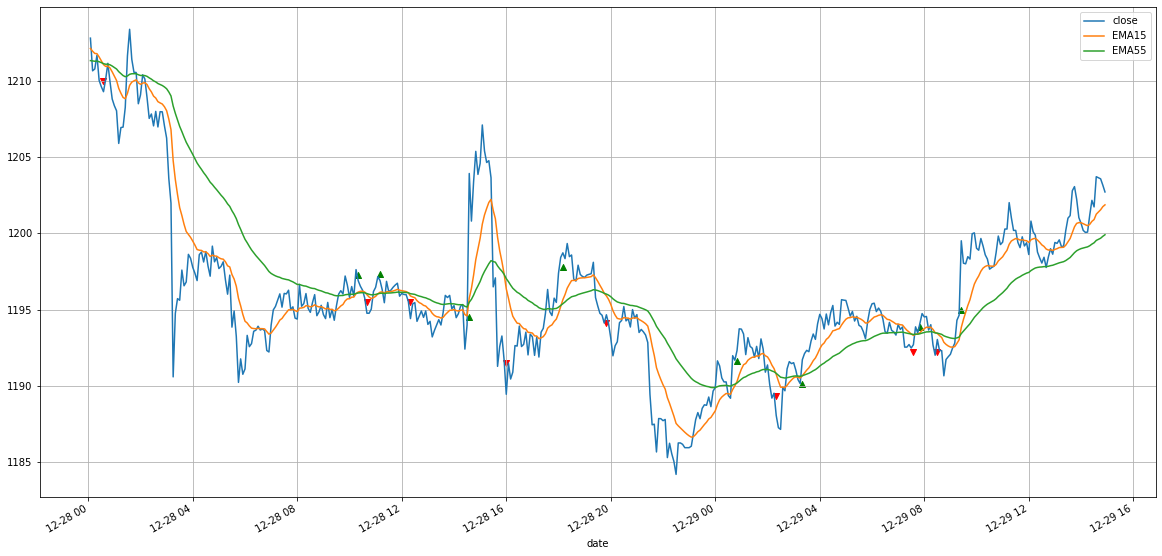

In [76]:
test = df[df['date'] > '2022-12-28 00:00:00.000']
test.plot(x='date', y=['close', 'EMA15', 'EMA55'], figsize=(20, 10))
plt.scatter(test[test['action'] == 'Buy']['date'], test[test['action'] == 'Buy']['open'], marker='^', color='green')
plt.scatter(test[test['action'] == 'Sell']['date'], test[test['action'] == 'Sell']['open'], marker='v', color='red')
plt.grid()
plt.show()

In [61]:
pnl = backtest(df, initial_capital=1000, taker_fee=0.0006, leverage=5)

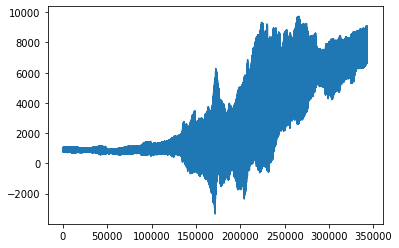

In [62]:
plt.plot(pnl)
plt.show()